In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sentiment-prediction-on-movie-reviews-term-break1/sample (1).csv
/kaggle/input/sentiment-prediction-on-movie-reviews-term-break1/test.csv (1)/test.csv
/kaggle/input/sentiment-prediction-on-movie-reviews-term-break1/movies.csv (1)/movies.csv
/kaggle/input/sentiment-prediction-on-movie-reviews-term-break1/train.csv (1)/train.csv


In [2]:
training_data = pd.read_csv('/kaggle/input/sentiment-prediction-on-movie-reviews-term-break1/train.csv (1)/train.csv')

# **Exploratory data analysis (EDA)**

In [3]:
print(training_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162758 entries, 0 to 162757
Data columns (total 5 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   movieid             162758 non-null  object
 1   reviewerName        162758 non-null  object
 2   isFrequentReviewer  162758 non-null  bool  
 3   reviewText          156311 non-null  object
 4   sentiment           162758 non-null  object
dtypes: bool(1), object(4)
memory usage: 5.1+ MB
None


In [4]:
print(training_data.describe())

                                            movieid     reviewerName  \
count                                        162758           162758   
unique                                        16812             4482   
top     escape_the_terminator_tyler_durden_astonish  Sherri Morrison   
freq                                            708              962   

       isFrequentReviewer               reviewText sentiment  
count              162758                   156311    162758  
unique                  2                   155071         2  
top                 False  Parental Content Review  POSITIVE  
freq               113189                       29    108761  


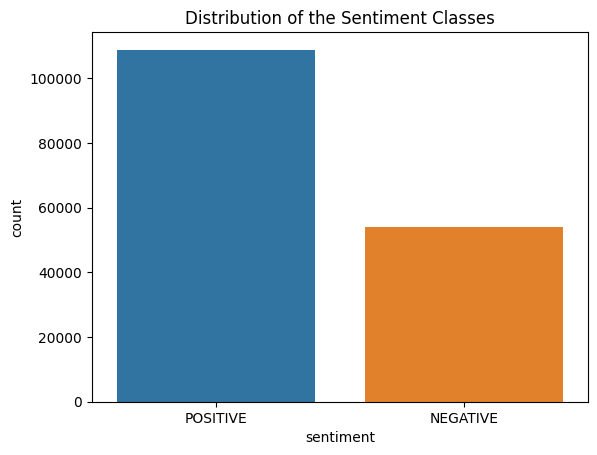

In [5]:
# Exploring the distribution of the sentiment classes

import seaborn as sns
import matplotlib.pyplot as plt
sns.countplot(x='sentiment', data=training_data)
plt.title('Distribution of the Sentiment Classes')
plt.show()

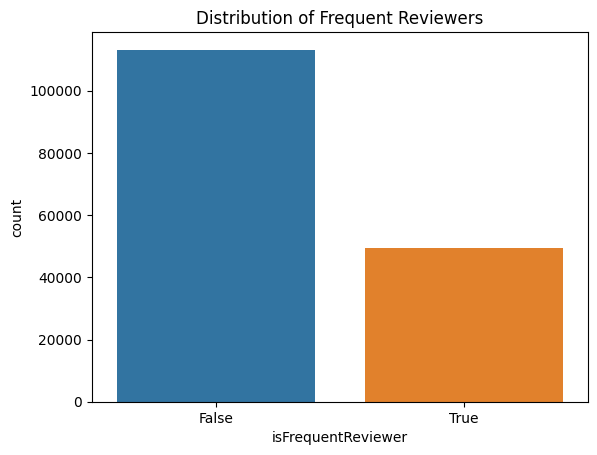

In [6]:
# Exploring the distribution of the frequent reviewers

sns.countplot(x='isFrequentReviewer', data=training_data)
plt.title('Distribution of Frequent Reviewers')
plt.show()

In [7]:
print(training_data.shape)
print(training_data.head(1))

(162758, 5)
            movieid    reviewerName  isFrequentReviewer  \
0  marvelous_pirate  Benjamin Henry               False   

                                          reviewText sentiment  
0  Henry Selick’s first movie since 2009’s Corali...  POSITIVE  


In [8]:
# Pairwise correlations
correlation_matrix = training_data.corr(numeric_only=True)
print(correlation_matrix)

                    isFrequentReviewer
isFrequentReviewer                 1.0


In [9]:
no_missing_values = training_data.isnull().sum()
print(no_missing_values)

movieid                  0
reviewerName             0
isFrequentReviewer       0
reviewText            6447
sentiment                0
dtype: int64


# **Data Preprocessing**

In [10]:
# Instead of missing data use use empty string
# Convert 'reviewText' to numerical features using TF-IDF
training_data['reviewText'].fillna('', inplace=True)

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
prepipe = Pipeline([('tfidf_vector',TfidfVectorizer(max_features=6000))]) # Adjust max_features as needed
X_data = prepipe.fit_transform(training_data['reviewText'])

In [11]:
# Spliting the data into feature and target 
x = X_data
y = training_data['sentiment']

In [12]:
# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
x_train, x_test_values, y_train, y_test_values = train_test_split(x, y, test_size=0.2, random_state=42)

In [13]:
import warnings

# To suppress all warnings:
warnings.filterwarnings("ignore")

# **logistic regression**

**Train**

In [14]:
# Hyperparameters
p_grid = {
    'C': [0.01, 0.1,0.5, 1, 10],  # Regularization strength
    'penalty': ['l1', 'l2'],   # Penalty 
    'max_iter': [50,75,100],   # Maximum number of iterations
}

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

class_model = LogisticRegression()       # Initialize
grid_search_cv = GridSearchCV(class_model, p_grid, cv=5, scoring = 'accuracy')  #Perform grid search with cross-validation
grid_search_cv.fit(x_train, y_train)


GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 0.5, 1, 10],
                         'max_iter': [50, 75, 100], 'penalty': ['l1', 'l2']},
             scoring='accuracy')

In [16]:
#best hyperparameters from GCV
best_parameters = grid_search_cv.best_params_
print(best_parameters)

{'C': 10, 'max_iter': 50, 'penalty': 'l2'}


In [17]:
# traning the modelwith best hyperperameters
logistic_best_model = LogisticRegression(**best_parameters)
logistic_best_model.fit(x_train, y_train)

LogisticRegression(C=10, max_iter=50)

In [18]:
#Predicting on the test set for hyperparameter tuning
y_predict = logistic_best_model.predict(x_test_values)

In [19]:
y_train_predict = logistic_best_model.predict(x_train)
y_test_predict = logistic_best_model.predict(x_test_values)

from sklearn.metrics import accuracy_score
accurace_train = accuracy_score(y_train_predict, y_train)
accurace_test = accuracy_score(y_test_predict, y_test_values)
print(f"Accuracy on training: {accurace_train:.3f}")
print(f"Accuracy on testing: {accurace_test:.3f}")


Accuracy on training: 0.810
Accuracy on testing: 0.789


**Test**

In [20]:
testing_data = pd.read_csv('/kaggle/input/sentiment-prediction-on-movie-reviews-term-break1/test.csv (1)/test.csv')

In [21]:
no_missing_values_test = testing_data.isnull().sum()
print(no_missing_values_test)

movieid            0
reviewerName       0
isTopCritic        0
reviewText      2510
dtype: int64


In [22]:
testing_data['reviewText'].fillna('', inplace=True)
x_test_tf = prepipe.transform(testing_data['reviewText'])

In [23]:
noo_missing_values_test = testing_data.isnull().sum()
print(noo_missing_values_test)

movieid         0
reviewerName    0
isTopCritic     0
reviewText      0
dtype: int64


In [24]:
prediction = logistic_best_model.predict(x_test_tf)

# **MultinomialNB**

**Train**

In [25]:
'''from sklearn.naive_bayes import MultinomialNB
mnb = MultinomialNB()
p_grid = {'alpha': [0.01, 0.05,0.07, 1.0, 2.0]} #used to handle the issue of zero probabilities when estimating class-conditional probabilities of features given a class in the MNB model
'''

"from sklearn.naive_bayes import MultinomialNB\nmnb = MultinomialNB()\np_grid = {'alpha': [0.01, 0.05,0.07, 1.0, 2.0]} #used to handle the issue of zero probabilities when estimating class-conditional probabilities of features given a class in the MNB model\n"

In [26]:
'''from sklearn.model_selection import GridSearchCV

grid_search_cv = GridSearchCV(mnb, p_grid, cv=5, scoring='accuracy')  #Perform grid search with cross-validation
grid_search_cv.fit(x_train, y_train)
'''

"from sklearn.model_selection import GridSearchCV\n\ngrid_search_cv = GridSearchCV(mnb, p_grid, cv=5, scoring='accuracy')  #Perform grid search with cross-validation\ngrid_search_cv.fit(x_train, y_train)\n"

In [27]:
#best hyperparameters from GCV
'''best_parameters = grid_search_cv.best_params_
print(best_parameters)
'''

'best_parameters = grid_search_cv.best_params_\nprint(best_parameters)\n'

In [28]:
#best_mnb_model = MultinomialNB(**best_parameters).fit(x_train,y_train)

In [29]:
'''y_train_predict = best_mnb_model.predict(x_train)
y_test_predict = best_mnb_model.predict(x_test_values)

from sklearn.metrics import accuracy_score
accurace_train = accuracy_score(y_train_predict, y_train)
accurace_test = accuracy_score(y_test_predict, y_test_values)
print(f"Accuracy on training: {accurace_train:.3f}")
print(f"Accuracy on testing: {accurace_test:.3f}")
'''

'y_train_predict = best_mnb_model.predict(x_train)\ny_test_predict = best_mnb_model.predict(x_test_values)\n\nfrom sklearn.metrics import accuracy_score\naccurace_train = accuracy_score(y_train_predict, y_train)\naccurace_test = accuracy_score(y_test_predict, y_test_values)\nprint(f"Accuracy on training: {accurace_train:.3f}")\nprint(f"Accuracy on testing: {accurace_test:.3f}")\n'

**Test**

In [30]:
'''testing_data = pd.read_csv('/kaggle/input/sentiment-prediction-on-movie-reviews-term-break1/test.csv (1)/test.csv')
no_missing_values_test = testing_data.isnull().sum()
print(no_missing_values_test)
'''

"testing_data = pd.read_csv('/kaggle/input/sentiment-prediction-on-movie-reviews-term-break1/test.csv (1)/test.csv')\nno_missing_values_test = testing_data.isnull().sum()\nprint(no_missing_values_test)\n"

In [31]:
'''testing_data['reviewText'].fillna('', inplace=True)
x_test_tf = prepipe.transform(testing_data['reviewText'])
noo_missing_values_test = testing_data.isnull().sum()
print(noo_missing_values_test)
'''

"testing_data['reviewText'].fillna('', inplace=True)\nx_test_tf = prepipe.transform(testing_data['reviewText'])\nnoo_missing_values_test = testing_data.isnull().sum()\nprint(noo_missing_values_test)\n"

In [32]:
#prediction = best_mnb_model.predict(x_test_tf)

# **SGDClassifier**

**Train**

In [33]:
'''from sklearn.linear_model import SGDClassifier
sgd = SGDClassifier(random_state=42)
'''

'from sklearn.linear_model import SGDClassifier\nsgd = SGDClassifier(random_state=42)\n'

In [34]:
#the hyperparameters to tune
'''p_grid = {
    "loss":["hinge","log"],
    "penalty": ["l1","l2"],
    "learning_rate": ["constant","optimal","invscaling","adaptive"]
}
'''

'p_grid = {\n    "loss":["hinge","log"],\n    "penalty": ["l1","l2"],\n    "learning_rate": ["constant","optimal","invscaling","adaptive"]\n}\n'

In [35]:
'''from sklearn.model_selection import GridSearchCV

grid_search_cv = GridSearchCV(sgd, p_grid, cv=5, scoring='accuracy')  #Perform grid search with cross-validation
grid_search_cv.fit(x_train, y_train)
'''

"from sklearn.model_selection import GridSearchCV\n\ngrid_search_cv = GridSearchCV(sgd, p_grid, cv=5, scoring='accuracy')  #Perform grid search with cross-validation\ngrid_search_cv.fit(x_train, y_train)\n"

In [36]:
#best hyperparameters from GCV
#best_parameters = grid_search_cv.best_params_
#print(best_parameters)

In [37]:
#best_sgd_model = SGDClassifier(**best_parameters).fit(x_train,y_train)

In [38]:
# Predicting on the test set for hyperparameter tuning
'''y_train_predict = best_sgd_model.predict(x_train)
y_test_predict = best_sgd_model.predict(x_test_values)

from sklearn.metrics import accuracy_score
accurace_train = accuracy_score(y_train_predict, y_train)
accurace_test = accuracy_score(y_test_predict, y_test_values)
print(f"Accuracy on training: {accurace_train:.3f}")
print(f"Accuracy on testing: {accurace_test:.3f}")
'''

'y_train_predict = best_sgd_model.predict(x_train)\ny_test_predict = best_sgd_model.predict(x_test_values)\n\nfrom sklearn.metrics import accuracy_score\naccurace_train = accuracy_score(y_train_predict, y_train)\naccurace_test = accuracy_score(y_test_predict, y_test_values)\nprint(f"Accuracy on training: {accurace_train:.3f}")\nprint(f"Accuracy on testing: {accurace_test:.3f}")\n'

**Test**

In [39]:
'''testing_data = pd.read_csv('/kaggle/input/sentiment-prediction-on-movie-reviews-term-break1/test.csv (1)/test.csv')
no_missing_values_test = testing_data.isnull().sum()
print(no_missing_values_test)
'''

"testing_data = pd.read_csv('/kaggle/input/sentiment-prediction-on-movie-reviews-term-break1/test.csv (1)/test.csv')\nno_missing_values_test = testing_data.isnull().sum()\nprint(no_missing_values_test)\n"

In [40]:
'''testing_data['reviewText'].fillna('', inplace=True)
x_test_tf = prepipe.transform(testing_data['reviewText'])
noo_missing_values_test = testing_data.isnull().sum()
print(noo_missing_values_test)
'''

"testing_data['reviewText'].fillna('', inplace=True)\nx_test_tf = prepipe.transform(testing_data['reviewText'])\nnoo_missing_values_test = testing_data.isnull().sum()\nprint(noo_missing_values_test)\n"

In [41]:
#prediction = best_sgd_model.predict(x_test_tf)

# **Sumbit**

In [42]:
submit = pd.DataFrame(columns=['id', 'sentiment'])
submit['id'] = [i for i in range(len(prediction))]
submit['sentiment'] = prediction

In [43]:
submit.to_csv('submission.csv',index=False)